Error Statistics:
  Max: 0.00929889184020251 %
  Min: -0.0008461428342571986 %
  Mean: 7.808896295103192e-06 %
  Median: 2.9018191455990546e-08 %
  Std: 5.0378886396367585e-05 %
  25th_percentile: -6.619856353928023e-08 %
  75th_percentile: 1.2774784823260273e-07 %


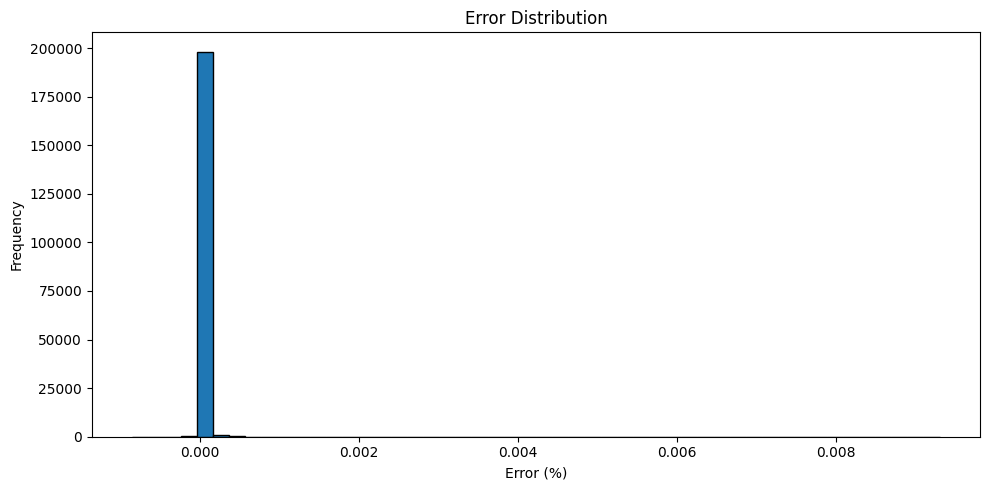

In [2]:
import core_FPGA as core
import torch
import numpy as np
from utils import create_input_tensor
import matplotlib.pyplot as plt

scale = 0.00112884

# Initialize model and set device
hidden_sizes = [core.N_HIDDEN_1, core.N_HIDDEN_2]
device = torch.device('cpu')
model = core.Digital_twin(core.N_INPUT, 1, hidden_sizes, scale, device).to(device)

# Matrix operations
def matrix_multiply_sw(A, B):
  return np.dot(A, B).astype(np.int64)

def matrix_add_sw(A, B):
  return (A + B).astype(np.int64)

def apply_relu_sw(matrix):
  return np.maximum(matrix, 0).astype(np.int64)

# Forward Pass
def forward_pass_sw(X, W1, b1, W2, b2, W3, b3):
  A1 = apply_relu_sw(matrix_add_sw(matrix_multiply_sw(W1, X), b1))
  A2 = apply_relu_sw(matrix_add_sw(matrix_multiply_sw(W2, A1), b2))
  return matrix_add_sw(matrix_multiply_sw(W3, A2), b3).astype(np.int64)

# Function to calculate error statistics
def calculate_error_stats(error_list):
  error_array = np.array(error_list)
  return {
      'max': np.max(error_array),
      'min': np.min(error_array),
      'mean': np.mean(error_array),
      'median': np.median(error_array),
      'std': np.std(error_array),
      '25th_percentile': np.percentile(error_array, 25),
      '75th_percentile': np.percentile(error_array, 75),
  }

# Initialize variables
N_RUNS = 100000
errors = []

# Run inference once to cache quantized weights and biases
in_float = create_input_tensor(core.N_INPUT, scale, device)
model.eval()
out_brevitas = model(in_float)

# Extract and convert weights and biases to numpy arrays
W1_sw = model.fc1.quant_weight().int().cpu().numpy().astype(np.int64)
b1_sw = model.fc1.quant_bias().int().cpu().numpy().astype(np.int64).reshape(-1, 1)
W2_sw = model.fc2.quant_weight().int().cpu().numpy().astype(np.int64)
b2_sw = model.fc2.quant_bias().int().cpu().numpy().astype(np.int64).reshape(-1, 1)
W3_sw = model.fc3.quant_weight().int().cpu().numpy().astype(np.int64)
b3_sw = model.fc3.quant_bias().int().cpu().numpy().astype(np.int64).reshape(-1, 1)

# Perform multiple runs to compare results
for _ in range(N_RUNS):
  in_float = create_input_tensor(core.N_INPUT, scale, device)
  try:
      out_brevitas = model(in_float)
      out_brevitas_int = out_brevitas.int().cpu().numpy().astype(np.int64)
  except Exception as e:
      print(f"Error occurred: {e}")
      print(f"Input tensor: {in_float}")
      continue

  X_sw = in_float.divide(scale).view(-1, 1).cpu().numpy().astype(np.int64)
  Y_pred_64 = forward_pass_sw(X_sw, W1_sw, b1_sw, W2_sw, b2_sw, W3_sw, b3_sw)

  # Calculate and append errors for both outputs
  for i in range(2):
      error = (out_brevitas_int[:, i] - Y_pred_64[i, 0]) / Y_pred_64[i, 0]
      errors.append(error[0])

# Calculate and print error statistics
stats = calculate_error_stats(errors)
print("Error Statistics:")
for stat_name, stat_value in stats.items():
  print(f"  {stat_name.capitalize()}: {stat_value} %")

# Plot error distribution
plt.figure(figsize=(10, 5))
plt.hist(errors, bins=50, edgecolor='black')
plt.title('Error Distribution')
plt.xlabel('Error (%)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [2]:
import random

In [4]:
def find_optimal_scale(min_scale=1/100000, max_scale=1., num_iterations=50, num_keep=10):
  def run_experiment(scale):
      print(f"\nRunning experiment with scale: {scale:.8f}")
      
      # Initialize model and set device
      hidden_sizes = [core.N_HIDDEN_1, core.N_HIDDEN_2]
      device = torch.device('cpu')
      
      N_RUNS = 10000
      errors = []
  
      for run in range(N_RUNS):
          model = core.Digital_twin(core.N_INPUT, 1, hidden_sizes, scale, device).to(device)
  
          # Run inference once to cache quantized weights and biases
          in_float = create_input_tensor(core.N_INPUT, scale, device)
          model.eval()
          out_brevitas = model(in_float)
  
          # Extract and convert weights and biases to numpy arrays
          W1_sw = model.fc1.quant_weight().int().cpu().numpy().astype(np.int64)
          b1_sw = model.fc1.quant_bias().int().cpu().numpy().astype(np.int64).reshape(-1, 1)
          W2_sw = model.fc2.quant_weight().int().cpu().numpy().astype(np.int64)
          b2_sw = model.fc2.quant_bias().int().cpu().numpy().astype(np.int64).reshape(-1, 1)
          W3_sw = model.fc3.quant_weight().int().cpu().numpy().astype(np.int64)
          b3_sw = model.fc3.quant_bias().int().cpu().numpy().astype(np.int64).reshape(-1, 1)
          
          in_float = create_input_tensor(core.N_INPUT, scale, device)
          
          try:
              out_brevitas = model(in_float)
              out_brevitas_int = out_brevitas.int().cpu().numpy().astype(np.int64)
          except Exception as e:
              print(f"Error occurred in run {run + 1}: {e}")
              print(f"Input tensor: {in_float}")
              continue
  
          X_sw = in_float.divide(scale).view(-1, 1).cpu().numpy().astype(np.int64)
          Y_pred_64 = forward_pass_sw(X_sw, W1_sw, b1_sw, W2_sw, b2_sw, W3_sw, b3_sw)
  
          for i in range(2):
              error = abs((out_brevitas_int[:, i] - Y_pred_64[i, 0]) / Y_pred_64[i, 0])
              errors.append(error[0])
  
      if (N_RUNS) % 1000 == 0:
          print(f"Completed {N_RUNS} runs")
  
      median_error = np.median(errors)
      print(f"Experiment results - Median error: {median_error:.8e} %")
      return median_error
  
  print("Starting weighted random search process to find the optimal scale")
  print(f"Search range: [{min_scale}, {max_scale}]")
  print(f"Number of iterations: {num_iterations}")
  
  log_min_scale = np.log10(min_scale)
  log_max_scale = np.log10(max_scale)
  
  scales = []
  errors = []
  all_scales = []
  all_errors = []
  
  best_scale = None
  best_error = float('inf')
  
  for iteration in range(num_iterations):
      print(f"\nIteration {iteration + 1}")
      
      if iteration < num_keep:
          # In the first few iterations, sample uniformly
          log_scale = random.uniform(log_min_scale, log_max_scale)
      else:
          # After that, use weighted sampling based on previous results
          weights = 1 / (np.array(errors) + 1e-10)  # Add small constant to avoid division by zero
          weights /= np.sum(weights)
          
          # Sample a previous scale
          sampled_log_scale = random.choices(scales, weights=weights)[0]
          
          # Add some noise to explore nearby values
          log_scale = np.clip(
              np.random.normal(sampled_log_scale, 0.5),  # std dev of 0.5 in log space
              log_min_scale,
              log_max_scale
          )
  
      scale = 10 ** log_scale
      error = run_experiment(float(scale))
  
      scales.append(log_scale)
      errors.append(error)
      all_scales.append(scale)
      all_errors.append(error)
  
      # Update best scale if current is better
      if error < best_error:
          best_scale = scale
          best_error = error
  
      # Keep only the best num_keep results
      if len(scales) > num_keep:
          sorted_indices = np.argsort(errors)
          scales = [scales[i] for i in sorted_indices[:num_keep]]
          errors = [errors[i] for i in sorted_indices[:num_keep]]
  
      print(f"Current best scale: {best_scale:.8f} with error: {best_error:.8e}")
      #print(f"Current best scale: {10**scales[0]:.8f} with error: {errors[0]}")
  
  print("\nWeighted random search complete")
  print(f"Best scale found: {best_scale:.8f}")
  print(f"Best error: {best_error:.8e}")
  
  # Plotting
  plt.figure(figsize=(12, 8))
  plt.scatter(all_scales, all_errors, alpha=0.6)
  plt.plot(best_scale, best_error, 'r*', markersize=20, label='Best Scale')
  plt.xscale('log')
  plt.yscale('log')
  plt.xlabel('Scale')
  plt.ylabel('Median Error')
  plt.title('Scale vs Median Error')
  plt.legend()
  plt.grid(True)
  plt.savefig('scale_optimization_results.png')
  plt.show()
  
  return best_scale, best_error

Starting weighted random search process to find the optimal scale
Search range: [1e-05, 1.0]
Number of iterations: 50

Iteration 1

Running experiment with scale: 0.05041988
Error occurred in run 7614: QuantTensor not valid.
Input tensor: tensor([[527.9969, 163.8646]])
Completed 10000 runs
Experiment results - Median error: 1.65882286e-07 %
Current best scale: 0.05041988 with error: 1.65882286e-07

Iteration 2

Running experiment with scale: 0.35395527
Error occurred in run 3377: QuantTensor not valid.
Input tensor: tensor([[1854.7256, 1293.3525]])
Completed 10000 runs
Experiment results - Median error: 1.66620902e-07 %
Current best scale: 0.05041988 with error: 1.65882286e-07

Iteration 3

Running experiment with scale: 0.00013610
Completed 10000 runs
Experiment results - Median error: 1.43642039e-07 %
Current best scale: 0.00013610 with error: 1.43642039e-07

Iteration 4

Running experiment with scale: 0.15832293
Completed 10000 runs
Experiment results - Median error: 1.57911896e-07 

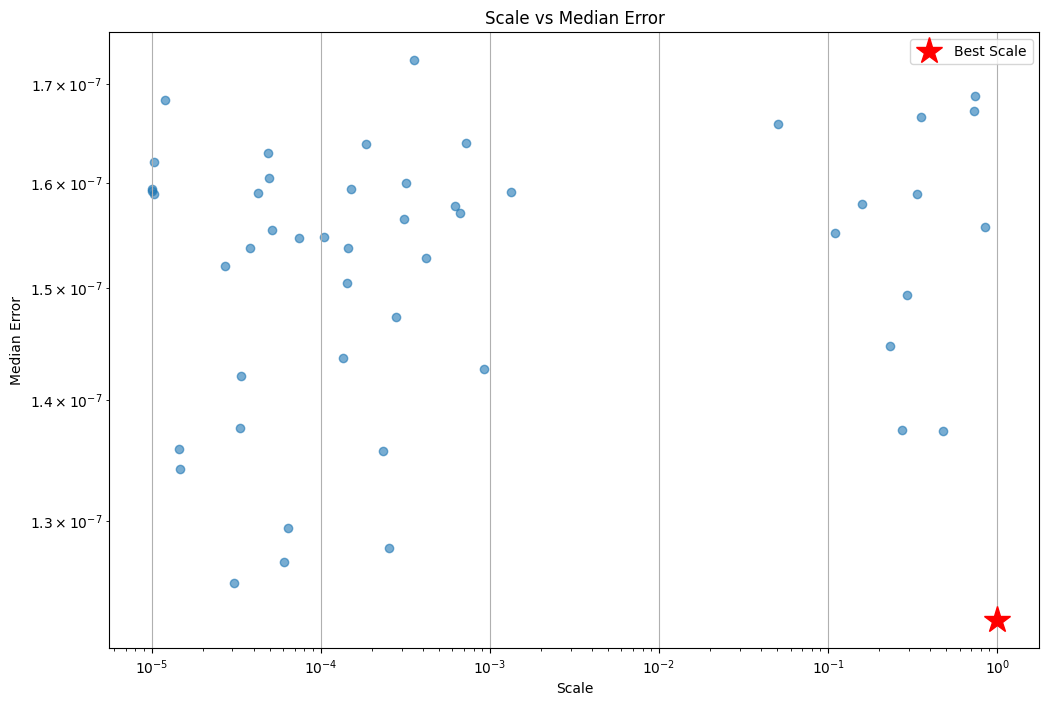


Final results:
Optimal scale: 1.0
Optimal median error: 1.2228916722790434e-07 %


In [5]:
# Run the optimization
optimal_scale, optimal_error = find_optimal_scale()
print(f"\nFinal results:")
print(f"Optimal scale: {optimal_scale}")
print(f"Optimal median error: {optimal_error} %")

In [6]:
# Plot error distribution for the optimal scale
scale = optimal_scale


In [7]:
# Initialize model and set device
hidden_sizes = [core.N_HIDDEN_1, core.N_HIDDEN_2]
device = torch.device('cpu')
model = core.Digital_twin(core.N_INPUT, 1, hidden_sizes, scale, device).to(device)

errors = []

# Run inference once to cache quantized weights and biases
in_float = create_input_tensor(core.N_INPUT, scale, device)
model.eval()
out_brevitas = model(in_float)

# Extract and convert weights and biases to numpy arrays
W1_sw = model.fc1.quant_weight().int().cpu().numpy().astype(np.int64)
b1_sw = model.fc1.quant_bias().int().cpu().numpy().astype(np.int64).reshape(-1, 1)
W2_sw = model.fc2.quant_weight().int().cpu().numpy().astype(np.int64)
b2_sw = model.fc2.quant_bias().int().cpu().numpy().astype(np.int64).reshape(-1, 1)
W3_sw = model.fc3.quant_weight().int().cpu().numpy().astype(np.int64)
b3_sw = model.fc3.quant_bias().int().cpu().numpy().astype(np.int64).reshape(-1, 1)

# Perform multiple runs to compare results
for _ in range(N_RUNS):
  in_float = create_input_tensor(core.N_INPUT, scale, device)
  try:
      out_brevitas = model(in_float)
      out_brevitas_int = out_brevitas.int().cpu().numpy().astype(np.int64)
  except Exception as e:
      print(f"Error occurred: {e}")
      print(f"Input tensor: {in_float}")
      continue

  X_sw = in_float.divide(scale).view(-1, 1).cpu().numpy().astype(np.int64)
  Y_pred_64 = forward_pass_sw(X_sw, W1_sw, b1_sw, W2_sw, b2_sw, W3_sw, b3_sw)

  # Calculate and append errors for both outputs
  for i in range(2):
      error = (out_brevitas_int[:, i] - Y_pred_64[i, 0]) / Y_pred_64[i, 0]
      errors.append(error[0])

# Calculate and print error statistics
stats = calculate_error_stats(errors)
print("Error Statistics:")
for stat_name, stat_value in stats.items():
  print(f"  {stat_name.capitalize()}: {stat_value} %")

# Plot error distribution
plt.figure(figsize=(10, 5))
plt.hist(errors, bins=50, edgecolor='black')
plt.title('Error Distribution')
plt.xlabel('Error (%)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

RuntimeError: expected m1 and m2 to have the same dtype, but got: double != float

In [ ]:
optimal_scale